# "American sign language classifier from scratch [99.63% accurate]"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [classifier, scratch, vision]
- image: images/asl.jpg
- hide: false
- author: Vinay Kudari
- search_exclude: true
- metadata_key1: deeplearning
- metadata_key2: image-classifier

Deep learning based image classifier written from scratch using PyTorch and some of the Fastai functions

![American Sign Language Classifier](images/asl.jpg "Credits: Dictionary.com")

Dataset: [Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist)

Benchmarks:
* ~99.63% accuracy with one layer of parameters and no pre-processing

In [1]:
from fastai.vision.all import *
import pandas as pd
from os import path
torch.cuda.set_device(0)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
if path.exists('/storage'):
    # Paperspace
    train_df = pd.read_csv('/storage/data/asl/sign_mnist_train.csv')
    test_df = pd.read_csv('/storage/data/asl/sign_mnist_test.csv')
elif path.exists('/Users/vinay/Datasets/'):
    # Local
    train_df = pd.read_csv('/Users/vinay/Datasets/asl/sign_mnist_train.csv')
    test_df = pd.read_csv('/Users/vinay/Datasets/asl/sign_mnist_test.csv')
else:
    # GCP
    train_df = pd.read_csv('/home/jupyter/datasets/asl/sign_mnist_train.csv')
    test_df = pd.read_csv('/home/jupyter/datasets/asl/sign_mnist_test.csv') 

# Randomly select 20% of training data as validation data
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index)

train_df.shape, valid_df.shape, test_df.shape

((21964, 785), (5491, 785), (7172, 785))

### Prepare dataset

The training data is arranged such that each row in the dataframe consists of an image and its corresponding label

In [3]:
# Select all the labels
def get_labels(df):
    return tensor(df.iloc[:, 0].values).to('cuda')

# Select all the pixel intensities and convert into a 1-D tensor of values between 0 to 1
def get_image_tensors(df):
    return torch.stack([tensor(image_array)/255. for image_array in df.iloc[:, 1:].values]).to('cuda')

def get_dataset(df):
    return zip(get_image_tensors(df), get_labels(df))

tensor(3)
tensor(6)


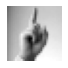

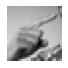

In [4]:
dataset = get_dataset(train_df)
labels = get_labels(train_df)

for image_tensor, label in list(dataset)[:2]:
    print(label)
    show_image(torch.reshape(image_tensor, (28, 28)), cmap='gray')

### Initialize weights

Generate random weights between -1 and 1 and mark them to calculate gradient by setting `.requires_grad_()` Autograd engine will track all the transformations/functions applied to weights in a graph structure (The leaves of this graph are input tensors and the roots are output tensors) and calculates the derivates when `.backward()` is called on the weights tensor.

> Important: Know more about PyTorch Autograd [here](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95)

In [10]:
def get_random_weights(rows, cols):
    return torch.randn(rows, cols).to('cuda').requires_grad_()

# pytorch equivalent
parameters_py = nn.Linear(28*28, len(train_df.label.unique())+1)
parameters_py

Linear(in_features=784, out_features=25, bias=True)

In [6]:
# each weight corresponds to each pixel of the input images
weights = get_random_weights(28*28, len(train_df.label.unique())+1)
bias = get_random_weights(1, len(train_df.label.unique())+1)
parameters = (weights, bias)

weights.shape, bias.shape

(torch.Size([784, 25]), torch.Size([1, 25]))

### Get Predictions 

To find predictions we need to multiply each weight with correponding pixel intensity, calculate the sum and add the bias this operation can be done without any loops by matrix multiplication

In [7]:
image_tensors = get_image_tensors(train_df)
image_tensors.shape, weights.shape

(torch.Size([21964, 784]), torch.Size([784, 25]))

In [8]:
def get_predictions(image_tensors, weights, bias):
    return image_tensors@weights + bias

In [9]:
predictions = get_predictions(image_tensors, weights, bias)
predictions.shape

torch.Size([21964, 25])

Predictions with random weights are around ~5% accurate, lets try to optimise them

In [19]:
def accuracy(df, parameters):
    weights, bias = parameters
    test_image_tensors, test_labels = get_image_tensors(valid_df), get_labels(valid_df)
    test_preds = get_predictions(test_image_tensors, weights, bias)
    pred_classes = torch.argmax(test_preds, dim=1)
    return (pred_classes == test_labels).float().mean() 

accuracy(valid_df, parameters)

tensor(0.0406)

### Calculate loss

A loss function is a measure of how good your prediction model is in terms of being able to predict accurately. We turn the learning problem into an optimization problem by defining a loss function and optimise the parameters to minimise the loss

![Softmax Function](images/softmax.png "Softmax function")

A softmax function turns predictions into probabilities, each value is bounded between (0, 1). Our model considers 0.900 and 0.999 as the same but the second prediction is 100 times more confident hence we use log to amplify the domain to (-inf, inf)

In [20]:
def softmax(predictions, log=False):
    if log:
        return torch.log(torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True))
    return torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True)

# pytorch equivalent
activations_py = F.log_softmax(predictions, dim=1)

In [21]:
# gathers the corresponsing loss according to the label class
activations = softmax(predictions, log=True)
loss_of_each_image = activations.gather(1, labels.unsqueeze(-1))
max(loss_of_each_image), min(loss_of_each_image), loss_of_each_image.shape

(tensor([0.], grad_fn=<SelectBackward>),
 tensor([-inf], grad_fn=<SelectBackward>),
 torch.Size([21964, 1]))

We can observe a problem here, If we are taking log after softmax we get loss as infinity to avoid that we use `F.log_softmax()` function provided by PyTorch

In [22]:
torch.log(F.softmax(tensor([62.0, -51.0]), dim=0)), F.log_softmax(tensor([62.0, -51.0]))

<ipython-input-22-6adc8555dfc7>:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.log(F.softmax(tensor([62.0, -51.0]), dim=0)), F.log_softmax(tensor([62.0, -51.0]))


(tensor([0., -inf]), tensor([   0., -113.]))

We now have 25 probabilities corresponding to 25 categories for each image, we select the value according to it class it belongs and take the mean of all the training images to calculate the loss.

In [25]:
# Example:
list_of_lists = tensor([[1, 2], [2, 5]])
index = tensor([0, 1])
list_of_lists.gather(1, index.unsqueeze(-1))

tensor([[1],
        [5]])

In [26]:
# gather will select values of each row of activations according to the index specified by labels
loss = activations_py.gather(1, labels.unsqueeze(-1)).mean()

# pytorch equivalent 
loss_py = -F.nll_loss(activations_py, labels)

loss, loss_py

(tensor(-40.5223, grad_fn=<MeanBackward0>),
 tensor(-40.5223, grad_fn=<NegBackward>))

In [27]:
# softmax + log + negative_loss_likelyhood = cross_entropy_loss: this can be used for classification problems
def cross_entropy_loss(predictions, labels): 
    activations = F.log_softmax(predictions, dim=1)
    loss = activations.gather(1, labels.unsqueeze(-1)).mean()
    return -loss

# pytorch equivalent
cross_entropy_loss_py = F.cross_entropy(predictions, labels)

cross_entropy_loss(predictions, labels), cross_entropy_loss_py

(tensor(40.5223, grad_fn=<NegBackward>),
 tensor(40.5223, grad_fn=<NllLossBackward>))

### Optimise weights

In [29]:
def train_epoch(dataloader, parameters, learning_rate, accuracy_func, loss_func, valid_df, epoch_no):
    for image_tensors, labels in dataloader:
        weights, bias = parameters
        preds = get_predictions(image_tensors, weights, bias)
        
        loss = cross_entropy_loss(preds, labels)
        loss.backward()
        
        weights.data = weights.data - weights.grad*learning_rate
        bias.data -= bias.grad*learning_rate
        weights.grad.zero_()
        bias.grad.zero_()
        
    accuracy = accuracy_func(valid_df, (weights, bias))
    if epoch_no%5 == 0:
        print(f'epoch={epoch_no}; loss={loss}; accuracy={accuracy}')
    return weights, bias

In [30]:
def train(parameters, no_of_epochs, learning_rate, batch_size):
    for i in range(1, no_of_epochs+1):
        dl = DataLoader(get_dataset(train_df), batch_size=batch_size)
        weights, bias = train_epoch(dl, parameters, learning_rate, accuracy, cross_entropy_loss, valid_df, i)

In [31]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=2048)

epoch=5; loss=7.723250865936279; accuracy=0.05882352963089943
epoch=10; loss=6.59684419631958; accuracy=0.07885631173849106
epoch=15; loss=5.713827133178711; accuracy=0.10872336477041245
epoch=20; loss=5.041042327880859; accuracy=0.13713349401950836
epoch=25; loss=4.521183967590332; accuracy=0.1637224555015564
epoch=30; loss=4.11172342300415; accuracy=0.18575851619243622
epoch=35; loss=3.7844295501708984; accuracy=0.20961573719978333
epoch=40; loss=3.5177741050720215; accuracy=0.23383718729019165
epoch=45; loss=3.2960424423217773; accuracy=0.2586049735546112
epoch=50; loss=3.108018636703491; accuracy=0.28337278962135315


We started with random parameters whos predictions are ~4% after training for 50 epochs I was able to achieve 28% accuracy, lets train for some more epochs

In [32]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=1024)

epoch=5; loss=2.7389485836029053; accuracy=0.3208887279033661
epoch=10; loss=2.5074076652526855; accuracy=0.34984520077705383
epoch=15; loss=2.3198177814483643; accuracy=0.38025858998298645
epoch=20; loss=2.163520574569702; accuracy=0.4079402685165405
epoch=25; loss=2.0304787158966064; accuracy=0.43398287892341614
epoch=30; loss=1.9153084754943848; accuracy=0.45784008502960205
epoch=35; loss=1.8142876625061035; accuracy=0.47532325983047485
epoch=40; loss=1.7247360944747925; accuracy=0.49280640482902527
epoch=45; loss=1.6446409225463867; accuracy=0.5070114731788635
epoch=50; loss=1.5724561214447021; accuracy=0.520852267742157


I'm trying to play with batch_size and learning rates to see how they effect the traning speed

In [33]:
train(parameters, no_of_epochs=50, learning_rate=2e-1, batch_size=512)

epoch=5; loss=1.4595612287521362; accuracy=0.5585503578186035
epoch=10; loss=1.2876158952713013; accuracy=0.6040793657302856
epoch=15; loss=1.157658576965332; accuracy=0.6421416997909546
epoch=20; loss=1.0544577836990356; accuracy=0.6709160208702087
epoch=25; loss=0.9689654111862183; accuracy=0.6958659291267395
epoch=30; loss=0.8959687352180481; accuracy=0.7175377607345581
epoch=35; loss=0.8325452208518982; accuracy=0.741030752658844
epoch=40; loss=0.7769091725349426; accuracy=0.7576033473014832
epoch=45; loss=0.7277417778968811; accuracy=0.7723547220230103
epoch=50; loss=0.6839793920516968; accuracy=0.788563072681427


Bumping up the learning rate indeed improved the optimisation speed, let train for some more epochs

In [34]:
train(parameters, no_of_epochs=50, learning_rate=2e-1, batch_size=512)

epoch=5; loss=0.6447545886039734; accuracy=0.8027681708335876
epoch=10; loss=0.6093621253967285; accuracy=0.8149699568748474
epoch=15; loss=0.577233076095581; accuracy=0.8229830265045166
epoch=20; loss=0.5479092597961426; accuracy=0.8319067358970642
epoch=25; loss=0.5210235714912415; accuracy=0.8402841091156006
epoch=30; loss=0.49628016352653503; accuracy=0.8466581702232361
epoch=35; loss=0.4734363555908203; accuracy=0.8553997278213501
epoch=40; loss=0.45229026675224304; accuracy=0.8639591932296753
epoch=45; loss=0.4326697885990143; accuracy=0.8721544146537781
epoch=50; loss=0.4144253730773926; accuracy=0.880167543888092


Lets try with a larger batch size and learning rate, maybe it generalises well?

In [35]:
train(parameters, no_of_epochs=50, learning_rate=3e-1, batch_size=1024)

epoch=5; loss=0.45226046442985535; accuracy=0.8226187825202942
epoch=10; loss=0.41609740257263184; accuracy=0.8228009343147278
epoch=15; loss=0.4397861361503601; accuracy=0.8209797739982605
epoch=20; loss=0.4218664765357971; accuracy=0.827353835105896
epoch=25; loss=0.42012253403663635; accuracy=0.8288107514381409
epoch=30; loss=0.40878626704216003; accuracy=0.8324530720710754
epoch=35; loss=0.3948947787284851; accuracy=0.8741576671600342
epoch=40; loss=0.39441171288490295; accuracy=0.8421052694320679
epoch=45; loss=0.3591289520263672; accuracy=0.8845382928848267
epoch=50; loss=0.3269328773021698; accuracy=0.8943725824356079


In [36]:
train(parameters, no_of_epochs=50, learning_rate=2e-1, batch_size=512)

epoch=5; loss=0.2853115499019623; accuracy=0.9286104440689087
epoch=10; loss=0.2771397829055786; accuracy=0.9318885207176208
epoch=15; loss=0.26912689208984375; accuracy=0.9358950853347778
epoch=20; loss=0.26137667894363403; accuracy=0.93917316198349
epoch=25; loss=0.25392618775367737; accuracy=0.9429976344108582
epoch=30; loss=0.2467852532863617; accuracy=0.9462757110595703
epoch=35; loss=0.23995234072208405; accuracy=0.9501001238822937
epoch=40; loss=0.2334199845790863; accuracy=0.9513749480247498
epoch=45; loss=0.227177232503891; accuracy=0.9535603523254395
epoch=50; loss=0.22121219336986542; accuracy=0.957202672958374


As we are now a bit above 95% accuracy, let try to take smaller steps to prevent overshooting

In [37]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=1024)

epoch=5; loss=0.21588782966136932; accuracy=0.9579311609268188
epoch=10; loss=0.21408985555171967; accuracy=0.9582953453063965
epoch=15; loss=0.21236322820186615; accuracy=0.9584774971008301
epoch=20; loss=0.21069581806659698; accuracy=0.9588417410850525
epoch=25; loss=0.20907911658287048; accuracy=0.9595701694488525
epoch=30; loss=0.2075067162513733; accuracy=0.9595701694488525
epoch=35; loss=0.20597346127033234; accuracy=0.9601165056228638
epoch=40; loss=0.20447543263435364; accuracy=0.9610270857810974
epoch=45; loss=0.20300959050655365; accuracy=0.9615734815597534
epoch=50; loss=0.20157337188720703; accuracy=0.9623019099235535


Can we get more out the single layer NN?

In [38]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=2048)

epoch=5; loss=0.20638421177864075; accuracy=0.9641230702400208
epoch=10; loss=0.20571450889110565; accuracy=0.9641230702400208
epoch=15; loss=0.20504949986934662; accuracy=0.9641230702400208
epoch=20; loss=0.2043890506029129; accuracy=0.9646694660186768
epoch=25; loss=0.20373308658599854; accuracy=0.9650336503982544
epoch=30; loss=0.20308151841163635; accuracy=0.9653978943824768
epoch=35; loss=0.20243410766124725; accuracy=0.9655800461769104
epoch=40; loss=0.20179085433483124; accuracy=0.9655800461769104
epoch=45; loss=0.2011517584323883; accuracy=0.965944230556488
epoch=50; loss=0.2005166858434677; accuracy=0.965944230556488


In [39]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=256)

epoch=5; loss=0.21264278888702393; accuracy=0.9639409780502319
epoch=10; loss=0.20781667530536652; accuracy=0.9661263823509216
epoch=15; loss=0.2031080722808838; accuracy=0.9674012064933777
epoch=20; loss=0.1985561102628708; accuracy=0.9688581228256226
epoch=25; loss=0.19416968524456024; accuracy=0.9703150391578674
epoch=30; loss=0.1899484097957611; accuracy=0.9723182916641235
epoch=35; loss=0.1858879029750824; accuracy=0.9750500321388245
epoch=40; loss=0.18198280036449432; accuracy=0.9768711924552917
epoch=45; loss=0.17822673916816711; accuracy=0.9781460165977478
epoch=50; loss=0.17461314797401428; accuracy=0.9797850847244263


Seems to me that having lower batch size is better? 

In [40]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=256)

epoch=5; loss=0.1711360067129135; accuracy=0.9810599088668823
epoch=10; loss=0.16778911650180817; accuracy=0.9825168251991272
epoch=15; loss=0.1645662933588028; accuracy=0.9836094975471497
epoch=20; loss=0.1614619493484497; accuracy=0.9845200777053833
epoch=25; loss=0.15847033262252808; accuracy=0.9852485656738281
epoch=30; loss=0.1555863618850708; accuracy=0.9865233898162842
epoch=35; loss=0.1528049111366272; accuracy=0.9872518181800842
epoch=40; loss=0.15012092888355255; accuracy=0.9874339699745178
epoch=45; loss=0.14753028750419617; accuracy=0.9885266423225403
epoch=50; loss=0.14502808451652527; accuracy=0.9892551302909851


I never assumed we could get 98.9% accurate model with just 1 layer, lets test the accuracy with test data

In [42]:
accuracy(test_df, (weights, bias))

tensor(0.9893)

In [43]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=256)

epoch=5; loss=0.14261044561862946; accuracy=0.9901657104492188
epoch=10; loss=0.14027352631092072; accuracy=0.9905299544334412
epoch=15; loss=0.13801345229148865; accuracy=0.9908941388130188
epoch=20; loss=0.1358269453048706; accuracy=0.9910762906074524
epoch=25; loss=0.13371039927005768; accuracy=0.9912583827972412
epoch=30; loss=0.13166065514087677; accuracy=0.9914405345916748
epoch=35; loss=0.12967489659786224; accuracy=0.9923511147499084
epoch=40; loss=0.12775032222270966; accuracy=0.9925332069396973
epoch=45; loss=0.12588419020175934; accuracy=0.9928974509239197
epoch=50; loss=0.12407400459051132; accuracy=0.9938080310821533


In [44]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=512)

epoch=5; loss=0.11372235417366028; accuracy=0.9952649474143982
epoch=10; loss=0.11295342445373535; accuracy=0.9954470992088318
epoch=15; loss=0.11219793558120728; accuracy=0.9956291913986206
epoch=20; loss=0.11145418137311935; accuracy=0.9958112835884094
epoch=25; loss=0.11072102189064026; accuracy=0.995993435382843
epoch=30; loss=0.10999791324138641; accuracy=0.995993435382843
epoch=35; loss=0.10928422957658768; accuracy=0.995993435382843
epoch=40; loss=0.10857987403869629; accuracy=0.9961755275726318
epoch=45; loss=0.10788467526435852; accuracy=0.9961755275726318
epoch=50; loss=0.10719814896583557; accuracy=0.9963576793670654


In [45]:
accuracy(test_df, (weights, bias))

tensor(0.9964)

Yea! its around 99.6% accurate. I still tried to train for more epochs but seemed to overfit (loss imporves but the accuracy decreases)